In [1]:
import pandas as pd
import sys
import glob
import numpy as np
import datetime

import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as PC

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

In [2]:
csv_filepath = "/pscratch/sd/o/ocankur/data/resource_usage_paper"

In [3]:
def get_duration(dataframe, seconds=10):
    # remove jobs that take less than 10 secs.
    dataframe["start_time"] = pd.to_datetime(dataframe["start"], unit='s', utc=True)
    dataframe["end_time"] = pd.to_datetime(dataframe["end"], unit='s', utc=True)
    dataframe["duration"] = dataframe["end_time"] - dataframe["start_time"]
    dataframe = dataframe[dataframe["duration"] > datetime.timedelta(0,seconds)]
    return dataframe

In [4]:
def preprocess_data(ldms_dataframe, sacct_dataframe, metric, percentage=True):
    """
    Remove jobs that take less than 10 seconds.
    Filter out completed jobs.
    Filter out 'nstaff' and 'nstaff_g'
    """
    
    print("Number of LDMS data points before preprocessing: ", len(ldms_dataframe.index))
    
    if percentage:
        if metric == "mem_copy_utilization" or metric == "gpu_utilization":
            ldms_dataframe = ldms_dataframe[ldms_dataframe[metric] <= 100].copy()
        else:
            ldms_dataframe = ldms_dataframe[ldms_dataframe[metric] <= 1].copy()
            ldms_dataframe.loc[:, metric] = ldms_dataframe[metric] * 100
    
    sacct_dataframe = get_duration(sacct_dataframe, 10)
    
    sacct_dataframe = sacct_dataframe[sacct_dataframe["Account"] != "nstaff_g"]
    sacct_dataframe = sacct_dataframe[sacct_dataframe["Account"] != "nstaff"]
    
    sacct_dataframe = sacct_dataframe[sacct_dataframe["state"] == "COMPLETED"]
    
    sacct_dataframe.rename(columns={'jobidraw': 'jobid'}, inplace=True)
    merged_ldms = ldms_dataframe.merge(sacct_dataframe, on=["ProducerName", "jobid", "step"])
    
    print("Number of LDMS data points after preprocessing: ", len(merged_ldms.index))
    
    return merged_ldms

In [5]:
df_gputil = pd.read_parquet(csv_filepath + "/" + "dcgm.gpu_utilization.1692169200.1692428399.8.16_ldms.pq")
df_sacct_gputil = pd.read_parquet(csv_filepath + "/" + "dcgm.gpu_utilization.1692169200.1692428399.8.16_saact.pq")
df_gputil = preprocess_data(df_gputil, df_sacct_gputil, metric="gpu_utilization", percentage=True)

df_gputil = df_gputil.iloc[:len(df_gputil) // 100]
df_gputil = df_gputil[['#Time', 'jobid', 'ProducerName', 'gpu_id', 'step', 'gpu_utilization']]

Number of LDMS data points before preprocessing:  116803958
Number of LDMS data points after preprocessing:  52268361


In [6]:
df_tensor = pd.read_parquet(csv_filepath + "/" + "dcgm.tensor_active.1692169200.1692428399.8.16_ldms.pq")
df_sacct_tensor = pd.read_parquet(csv_filepath + "/" + "dcgm.tensor_active.1692169200.1692428399.8.16_saact.pq")
df_tensor = preprocess_data(df_tensor, df_sacct_tensor, metric="tensor_active", percentage=True)

df_tensor = df_tensor.iloc[:len(df_tensor) // 100]
df_tensor = df_tensor[['#Time', 'jobid', 'ProducerName', 'gpu_id', 'step', 'tensor_active']]

Number of LDMS data points before preprocessing:  116807383
Number of LDMS data points after preprocessing:  52269956


In [5]:
df_sm_active = pd.read_parquet(csv_filepath + "/" + "dcgm.sm_active.1692169200.1692428399.8.16_ldms.pq")
df_sacct_sm_active = pd.read_parquet(csv_filepath + "/" + "dcgm.sm_active.1692169200.1692428399.8.16_saact.pq")
df_sm_active = preprocess_data(df_sm_active, df_sacct_sm_active, metric="sm_active", percentage=True)

df_sm_active = df_sm_active.iloc[:len(df_sm_active) // 20]
df_sm_active = df_sm_active[['#Time', 'jobid', 'ProducerName', 'gpu_id', 'step', 'sm_active']]

Number of LDMS data points before preprocessing:  116806253
Number of LDMS data points after preprocessing:  52270259


In [6]:
df_memcpy_utilization = pd.read_parquet(csv_filepath + "/" + "dcgm.mem_copy_utilization.1692169200.1692428399.8.16_ldms.pq")
df_sacct_memcpy_utilization = pd.read_parquet(csv_filepath + "/" + "dcgm.mem_copy_utilization.1692169200.1692428399.8.16_saact.pq")
df_memcpy_utilization = preprocess_data(df_memcpy_utilization, df_sacct_memcpy_utilization, metric="mem_copy_utilization", percentage=True)

df_memcpy_utilization = df_memcpy_utilization.iloc[:len(df_sm_active) // 20]
df_memcpy_utilization = df_memcpy_utilization[['#Time', 'jobid', 'ProducerName', 'gpu_id', 'step', 'mem_copy_utilization']]

Number of LDMS data points before preprocessing:  116806476
Number of LDMS data points after preprocessing:  52275495


## Correlations

- This is preliminary. Calculating correlation requires memory intensive operations.
- The idea is to investigate correlation between different metrics such as:
1. GPU Utilization vs. Tensor Active
2. GPU Utilization vs. SM Occupancy/SM Active
3. GPU Utilization vs. NVLink Bandwidth Total
4. GPU Utilization vs. Memory Metrics (fb_used, fb_free, mem_copy_utilization)
5. Memory Metrics vs SM Occupancy/SM Active

#### GPU Utilization and Tensor Active
- TODO: Remove zero values?? Think about this later. I am not sure what we can learn from this.

In [7]:
merged_heatmap = df_tensor[["#Time", "ProducerName", "gpu_id", "jobid", "step", "tensor_active"]].merge(df_gputil[["#Time", "ProducerName", "gpu_id", "jobid", "step", "gpu_utilization"]], 
                                                                                                on=["#Time", "ProducerName", "gpu_id", "jobid", "step"], how='inner')
merged_heatmap = merged_heatmap.drop_duplicates()
print("Number of rows after 1st merge: ", len(merged_heatmap.index))

Number of rows after 1st merge:  80328


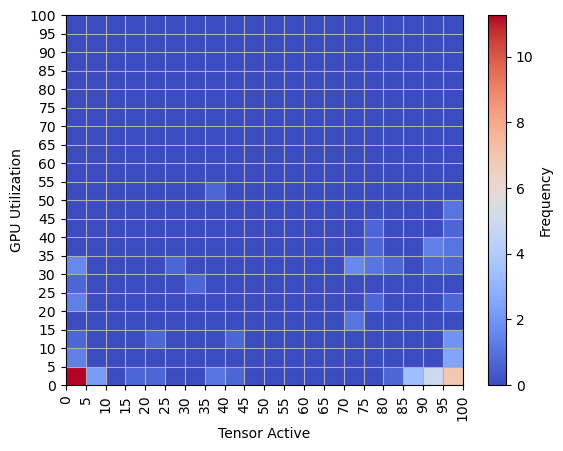

In [8]:
x_axis_data = merged_heatmap["tensor_active"] * 100
y_axis_data = merged_heatmap["gpu_utilization"]

xticks = np.arange(0.0, 100.05, 5)
yticks = np.arange(0.0, 100.05, 5)

hist, xedges, yedges = np.histogram2d(x_axis_data, y_axis_data, bins=(xticks, yticks))
hist = np.log(hist, out=np.zeros_like(hist), where=(hist!=0))

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.imshow(hist, extent=extent, origin='lower', cmap='coolwarm', aspect='auto')
plt.colorbar(label='Frequency')  # Add color bar with label

# Annotate the heatmap with numbers
# for i in range(len(yedges) - 1):
#     for j in range(len(xedges) - 1):
#         plt.text(xedges[j] + 0.5, yedges[i] + 0.5, int(hist[i, j]),
#                  color='white', ha='center', va='center', fontsize=8)

plt.xlabel('Tensor Active')
plt.ylabel('GPU Utilization')

plt.xticks(xedges, rotation=90)
plt.yticks(yedges)

plt.grid(True)
plt.show()


In [10]:
correlation = merged_heatmap[['gpu_utilization', 'tensor_active']].corr()
correlation

,gpu_utilization,tensor_active
gpu_utilization,1.000000,0.478959
tensor_active,0.478959,1.000000


## Distribution of ratios
- How can we answer the following question: What is the relative benefit of adding more SMs versus increasing memory bandwidth?
- I don't think exploring the distribution of ratios is a very good technique to answer this.

In [7]:
merged_heatmap = df_sm_active[["#Time", "ProducerName", "gpu_id", "jobid", "step", "sm_active"]].merge(df_memcpy_utilization[["#Time", "ProducerName", "gpu_id", "jobid", "step", "mem_copy_utilization"]], 
                                                                                                on=["#Time", "ProducerName", "gpu_id", "jobid", "step"], how='inner')
merged_heatmap = merged_heatmap.drop_duplicates()
print("Number of rows after 1st merge: ", len(merged_heatmap.index))

Number of rows after 1st merge:  49480


In [8]:
merged_heatmap["sm/memcpy"] = merged_heatmap["sm_active"] / merged_heatmap["mem_copy_utilization"]
merged_heatmap.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_heatmap.dropna(subset=["sm/memcpy"], how="all", inplace=True)

In [9]:
merged_heatmap

,#Time,ProducerName,gpu_id,jobid,step,sm_active,mem_copy_utilization,sm/memcpy
2960,1692299110,login01,0,13651012,4294967292,65.4584,50.0,1.309168
3104,1692311130,login01,0,13651012,4294967292,87.3821,47.0,1.859194
233215,1692252010,login01,0,8406623,4294967292,94.9974,64.0,1.484334
234440,1692252020,login01,0,8406623,4294967292,95.3670,55.0,1.733945
235665,1692252030,login01,0,8406623,4294967292,95.5605,45.0,2.123567
...,...,...,...,...,...,...,...,...
494320,1692186700,login04,0,10778925,4294967292,92.7566,7.0,13.250943
494321,1692186710,login04,0,10778925,4294967292,94.2310,3.0,31.410333
3422431,1692310700,login04,0,9484355,4294967291,67.6349,21.0,3.220710
3422435,1692310710,login04,0,9484355,4294967291,68.6248,24.0,2.859367


Text(0.5, 1.0, 'Distribution of SM_ACTIVE/MEM_COPY_UTILIZATION after preprocessing')

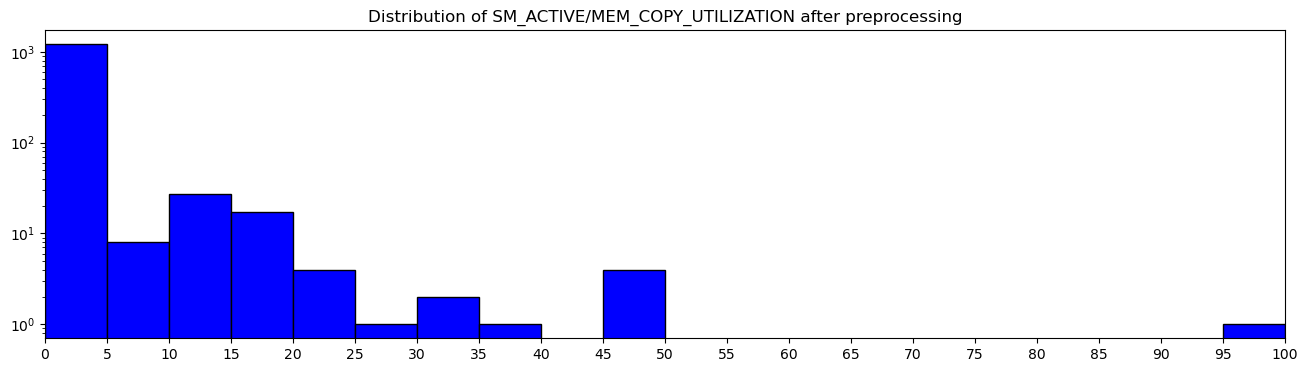

In [13]:
fig, axis = plt.subplots(figsize=(16, 4))
bin_edges = np.arange(0, 105, 5)
hist_values, bin_edges, _ = plt.hist(merged_heatmap["sm/memcpy"], bins=bin_edges, color='blue', edgecolor="black")

axis.set_xlim(0, 100)
plt.xticks(bin_edges)
plt.yscale('log')
plt.title("Distribution of SM_ACTIVE/MEM_COPY_UTILIZATION after preprocessing")

## Other ideas I have in mind:
- Analyze how the metrics correlate over different times of the day. This can help identify peak usage times and potential patterns.
- Investigate if there's a time lag between peaks in different metrics. For instance, a spike in GPU utilization might be followed by a spike in memory usage.
- Isolate jobs identified as deep learning and see if the correlations are stronger or different compared to other jobs.
- Compute aggregate statistics (e.g., mean, median, max) for each job and analyze correlations at the job level.
- Use tree-based models to predict GPU utilization. These models provide feature importance scores, indicating which features (SM activity or memory bandwidth) have a greater impact on GPU utilization.
- Perform cross-correlation analysis to see how changes in SM activity and memory bandwidth over time impact GPU utilization.